In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.utils import np_utils
from keras.models import Sequential, Graph
from keras.layers.core import Dense, Dropout, Activation, TimeDistributedDense, Flatten, Reshape, Permute, Merge, LambdaMerge, Lambda

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [2]:
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D, UpSampling1D, UpSampling2D

In [3]:
from keras.callbacks import ModelCheckpoint, Callback

In [5]:
import matplotlib.pyplot as plt

In [6]:
import sys
sys.path.insert(0, '../models')

In [8]:
from UFCNN1 import 

In [4]:
%matplotlib inline

In [73]:
def draw_model(model):
    from IPython.display import SVG
    from keras.utils.visualize_util import to_graph
    from keras.utils.visualize_util import plot

    SVG(to_graph(model).create(prog='dot', format='svg'))
    plot(model, to_file='UFCNN/UFCNN_1.png')

In [63]:
def print_nodes_shapes(model):
    for k, v in model.inputs.items():
        print("{} : {} : {} : {}".format(k, type(v), v.input_shape, v.output_shape))
        
    for k, v in model.nodes.items():
        print("{} : {} : {} : {}".format(k, type(v), v.input_shape, v.output_shape))
        
    for k, v in model.outputs.items():
        print("{} : {} : {} : {}".format(k, type(v), v.input_shape, v.output_shape))

In [54]:
def ufcnn_regression_model(sequence_length=5000,
                           features=1,
                           nb_filter=150,
                           filter_length=5,
                           output_dim=1,
                           optimizer='adagrad',
                           loss='mse'):
    model = Graph()
    model.add_input(name='input', input_shape=(sequence_length, features))
    #########################################################
    model.add_node(Convolution1D(nb_filter=nb_filter, filter_length=filter_length, border_mode='same'), name='conv1', input='input')
    model.add_node(Activation('relu'), name='relu1', input='conv1')
    #########################################################
    model.add_node(Convolution1D(nb_filter=nb_filter, filter_length=filter_length, border_mode='same'), name='conv2', input='relu1')
    model.add_node(Activation('relu'), name='relu2', input='conv2')
    #########################################################
    model.add_node(Convolution1D(nb_filter=nb_filter, filter_length=filter_length, border_mode='same'), name='conv3', input='relu2')
    model.add_node(Activation('relu'), name='relu3', input='conv3')
    #########################################################
    model.add_node(Convolution1D(nb_filter=nb_filter, filter_length=filter_length, border_mode='same'), name='conv4', input='relu3')
    model.add_node(Activation('relu'), name='relu4', input='conv4')
    #########################################################
    model.add_node(Convolution1D(nb_filter=nb_filter,filter_length=filter_length, border_mode='same'),
                     name='conv5',
                     inputs=['relu2', 'relu4'],
                     merge_mode='sum')
    model.add_node(Activation('relu'), name='relu5', input='conv5')
    #########################################################
    model.add_node(Convolution1D(nb_filter=nb_filter,filter_length=filter_length, border_mode='same'),
                     name='conv6',
                     inputs=['relu1', 'relu5'],
                     merge_mode='sum')
    model.add_node(Activation('relu'), name='relu6', input='conv6')
    #########################################################
    model.add_node(Convolution1D(nb_filter=output_dim, filter_length=filter_length, border_mode='same'), name='conv7', input='relu6')
    #########################################################
    model.add_output(name='output', input='conv7')
    
    model.compile(optimizer=optimizer, loss={'output': loss})
    
    return model

In [66]:
def gen_cosine_amp(amp=100, period=25, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
	Ernst 20160301 from https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py
        as a first test for the ufcnn
    """
    
    cos = np.zeros(((xn - x0) * step,  1, 1))
    print("Cos. Shape",cos.shape)
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(idx / (2 * np.pi * period))
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

In [67]:
def train_and_predict_regression(model, sequence_length=5000, batch_size=128, epochs=5):
    lahead = 1

    cos = gen_cosine_amp(xn = sequence_length * 100)

    expected_output = np.zeros((len(cos), 1, 1))

    for i in range(len(cos) - lahead):
        expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

    print('Training')
    for i in range(epochs):
        print('Epoch', i, '/', epochs)
        model.fit({'input': cos, 'output': expected_output},
                  verbose=1,
                  nb_epoch=1,
                  shuffle=False,
                  batch_size=batch_size)

    print('Predicting')
    predicted_output = model.predict({'input': cos,}, batch_size=batch_size)
    
    return {'model': model, 'predicted_output': predicted_output, 'expected_output': expected_output}

In [4]:
#########################################################
## Test the net with damped cosine  / remove later...
#########################################################

sequence_length = 64      # same as in Roni Mittelman's paper
features = 1                # guess changed Ernst 20160301
nb_filter = 150             # same as in Roni Mittelman's paper
filter_length = 5           # same as in Roni Mittelman's paper
output_dim = 1              # guess changed Ernst 20160301

In [68]:
UFCNN_1 = ufcnn_regression_model(sequence_length=sequence_length)

In [69]:
print_nodes_shapes(UFCNN_1)

input : <class 'keras.layers.core.Layer'> : (None, 64, 1) : (None, 64, 1)
conv1 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 64, 1) : (None, 64, 150)
relu1 : <class 'keras.layers.core.Activation'> : (None, 64, 150) : (None, 64, 150)
conv2 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 64, 150) : (None, 64, 150)
relu2 : <class 'keras.layers.core.Activation'> : (None, 64, 150) : (None, 64, 150)
conv3 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 64, 150) : (None, 64, 150)
relu3 : <class 'keras.layers.core.Activation'> : (None, 64, 150) : (None, 64, 150)
conv4 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 64, 150) : (None, 64, 150)
relu4 : <class 'keras.layers.core.Activation'> : (None, 64, 150) : (None, 64, 150)
conv5 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 64, 150) : (None, 64, 150)
relu5 : <class 'keras.layers.core.Activation'> : (None, 64, 150) : (None, 64, 150)
conv6 : <class 'keras.layers.convoluti

In [70]:
case_1 = train_and_predict_regression(UFCNN_1, sequence_length=sequence_length)

Cos. Shape (6400, 1, 1)
Training
Epoch 0 / 5
Epoch 1/1
6400/6400 [==============================] - 18s - loss: 875.0879    
Epoch 1 / 5
Epoch 1/1
6400/6400 [==============================] - 18s - loss: 1.1201    
Epoch 2 / 5
Epoch 1/1
6400/6400 [==============================] - 18s - loss: 1.1014    
Epoch 3 / 5
Epoch 1/1
6400/6400 [==============================] - 18s - loss: 0.9741    
Epoch 4 / 5
Epoch 1/1
6400/6400 [==============================] - 18s - loss: 0.9942    
Predicting


Ploting Results


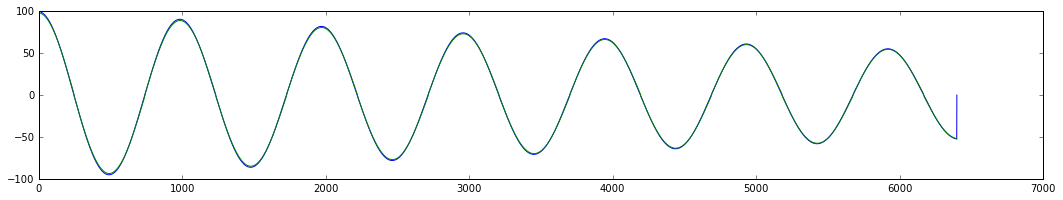

In [72]:
print('Ploting Results')
plt.figure(figsize=(18,3))
plt.plot(case_1['expected_output'].reshape(-1)[-10000:]) #, predicted_output['output'].reshape(-1))
plt.plot(case_1['predicted_output']['output'].reshape(-1)[-10000:])
#plt.savefig('sinus.png')
plt.show()

Ploting Results


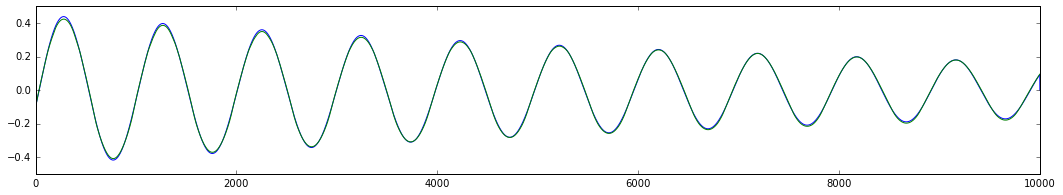

In [41]:
print('Ploting Results')
plt.figure(figsize=(18,3))
#plt.subplot(2, 1, 1)
plt.plot(expected_output.reshape(-1)[-10000:]) #, predicted_output['output'].reshape(-1))
#plt.title('Expected')
#plt.subplot(2, 1, 2)
plt.plot(predicted_output['output'].reshape(-1)[-10000:])
#plt.title('Predicted')
#plt.savefig('sinus.png')
#plt.show()

In [55]:
UFCNN_2 = ufcnn_regression_model()

In [58]:
print_nodes_shapes(UFCNN_2)

input : <class 'keras.layers.core.Layer'> : (None, 5000, 1) : (None, 5000, 1)
conv1 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 5000, 1) : (None, 5000, 150)
relu1 : <class 'keras.layers.core.Activation'> : (None, 5000, 150) : (None, 5000, 150)
conv2 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 5000, 150) : (None, 5000, 150)
relu2 : <class 'keras.layers.core.Activation'> : (None, 5000, 150) : (None, 5000, 150)
conv3 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 5000, 150) : (None, 5000, 150)
relu3 : <class 'keras.layers.core.Activation'> : (None, 5000, 150) : (None, 5000, 150)
conv4 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 5000, 150) : (None, 5000, 150)
relu4 : <class 'keras.layers.core.Activation'> : (None, 5000, 150) : (None, 5000, 150)
conv5 : <class 'keras.layers.convolutional.Convolution1D'> : (None, 5000, 150) : (None, 5000, 150)
relu5 : <class 'keras.layers.core.Activation'> : (None, 5000, 150) : (None, 5000,

In [62]:
case_2 = train_and_predict_regression(UFCNN_2)

Cos. Shape (50000, 1, 1)
Training
Epoch 0 / 5
Epoch 1/1
50000/50000 [==============================] - 144s - loss: 0.1451   
Epoch 1 / 5
Epoch 1/1
50000/50000 [==============================] - 162s - loss: 3.6177   
Epoch 2 / 5
Epoch 1/1
50000/50000 [==============================] - 326s - loss: 0.3030   
Epoch 3 / 5
Epoch 1/1
50000/50000 [==============================] - 323s - loss: 0.1347   
Epoch 4 / 5
Epoch 1/1
50000/50000 [==============================] - 278s - loss: 0.0849   
Predicting


Ploting Results


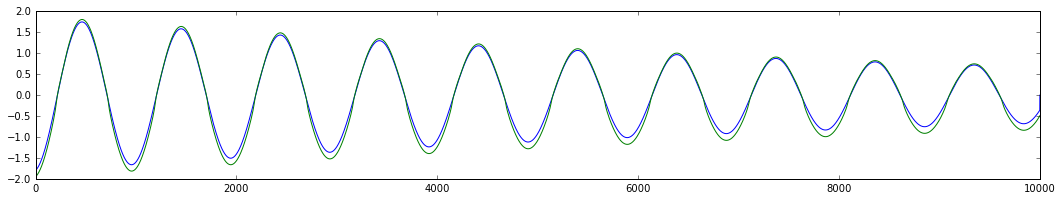

In [71]:
print('Ploting Results')
plt.figure(figsize=(18,3))
plt.plot(case_2['expected_output'].reshape(-1)[-10000:]) #, predicted_output['output'].reshape(-1))
plt.plot(case_2['predicted_output']['output'].reshape(-1)[-10000:])
#plt.savefig('sinus.png')
plt.show()